In [1]:
library(NBZIMM)
library(car)
library(PerformanceAnalytics)

Warning message:
“package ‘car’ was built under R version 3.6.3”Loading required package: carData
Warning message:
“package ‘carData’ was built under R version 3.6.3”Warning message:
“package ‘PerformanceAnalytics’ was built under R version 3.6.3”Loading required package: xts
Warning message:
“package ‘xts’ was built under R version 3.6.3”Loading required package: zoo
Warning message:
“package ‘zoo’ was built under R version 3.6.3”
Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Attaching package: ‘PerformanceAnalytics’

The following object is masked from ‘package:graphics’:

    legend



[1] -5.115996


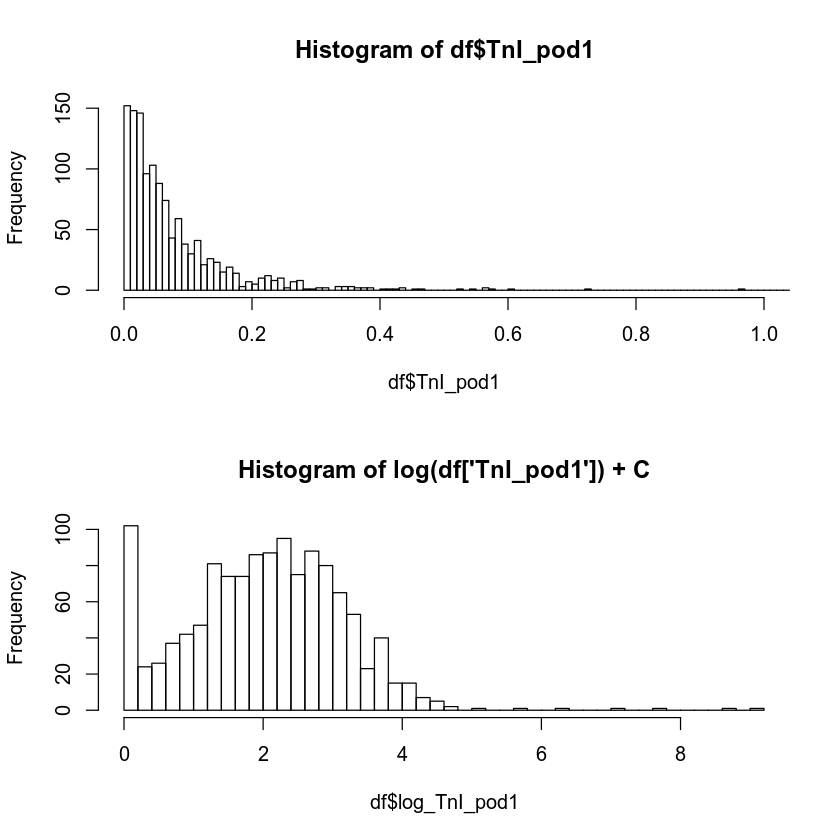

In [21]:
df = read.csv("../imputed_data/troponin_pod1_regression_imputed_data01.csv")

par(mfrow = c(2,1))
hist(df$TnI_pod1, breaks=5000, xlim=c(0, 1))

df$log_TnI_pod1 = log(df$TnI_pod1)
print(min(df$log_TnI_pod1))
df$log_TnI_pod1 = df$log_TnI_pod1 - min(df$log_TnI_pod1)
df$Tnl_reperfusion = log(df$Tnl_reperfusion)
df$Tnl_anhe = log(df$Tnl_anhe)
df$Tnl_ind = log(df$Tnl_ind)

hist(df$log_TnI_pod1, breaks=50, main="Histogram of log(df['TnI_pod1']) + C")

df$Subject = seq(1, nrow(df))
Ntrain <- floor(0.8 * nrow(df))
set.seed(123)
train_ind <- sample(seq_len(nrow(df)), size = Ntrain)

train <- df[train_ind, ]
test <- df[-train_ind, ]

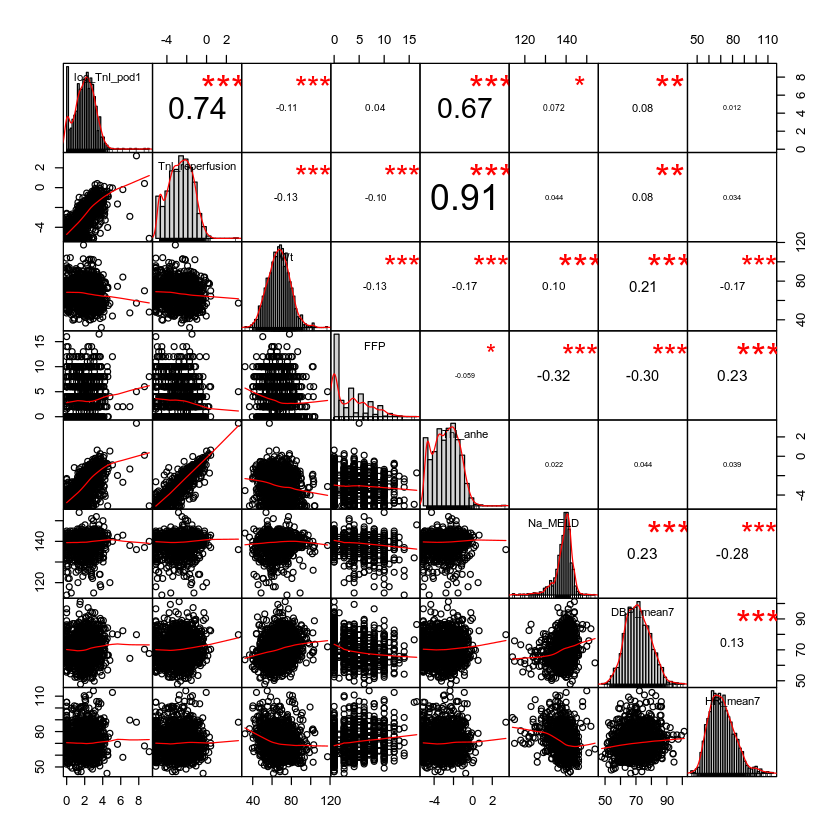

In [3]:
cor <- df[, c('log_TnI_pod1', 'Tnl_reperfusion', 'Wt', 'FFP', 
              'Tnl_anhe', 'Na_MELD', 'DBP_mean7', 'HR_mean7')]
#categorical_vars <- c('Sex')
#cor[,categorical_vars] <- lapply(cor[, categorical_vars], as.numeric)
chart.Correlation(cor, histogram=TRUE, pch=1, cex.cor.scale=1.5)

lme.zig reference: https://rdrr.io/github/nyiuab/NBZIMM/man/lme.zig.html

In [4]:
r2_general <-function(preds,actual){ 
  return(1- sum((preds - actual) ^ 2)/sum((actual - mean(actual))^2))
}

In [5]:
f = lme.zig(fixed = log_TnI_pod1 ~ Tnl_reperfusion + FFP + Wt 
                    + Na_MELD + DBP_mean7 + HR_mean7, #+ Tnl_ind, 
            random = ~ 1|op_mon, data = train) 
summary(f)
#fixed(f)
#summary(f$fit.zero)
#predict(f, test)
#plot(test$TnI_pod1, predict(f, test))
#plot(test$TnI_pod1, f$residuals)
#predict(f, test)
#plot(test$log_TnI_pod1, predict(f, test))
print(paste('Test-set RMSE =', sqrt(sum((test$log_TnI_pod1-predict(f, test))^2))/length(test)))
print(paste('Test-set R^2 =', r2_general(predict(f, test), test$log_TnI_pod1)))
print(paste('Train-set R^2 =', r2_general(predict(f, train), train$log_TnI_pod1)))

Loading required namespace: nlme
Loading required namespace: MASS
Warning message:
“package ‘nlme’ was built under R version 3.6.3”Warning message:
“package ‘MASS’ was built under R version 3.6.3”

Computational iterations: 4 
Computational time: 0.005 minutes 


Linear mixed-effects model fit by maximum likelihood
 Data: train 
  AIC BIC logLik
   NA  NA     NA

Random effects:
 Formula: ~1 | op_mon
         (Intercept) Residual
StdDev: 2.241144e-05 0.774807

Variance function:
 Structure: fixed weights
 Formula: ~invwt 
Fixed effects: log_TnI_pod1 ~ Tnl_reperfusion + FFP + Wt + Na_MELD + DBP_mean7 +      HR_mean7 
                     Value Std.Error  DF  t-value p-value
(Intercept)      1.0726617 0.9445060 982  1.13569  0.2564
Tnl_reperfusion  0.6456970 0.0193759 982 33.32474  0.0000
FFP              0.0513445 0.0078534 982  6.53785  0.0000
Wt              -0.0039146 0.0023114 982 -1.69363  0.0907
Na_MELD          0.0186506 0.0064566 982  2.88863  0.0040
DBP_mean7        0.0082357 0.0033791 982  2.43723  0.0150
HR_mean7        -0.0039719 0.0024901 982 -1.59509  0.1110
 Correlation: 
                (Intr) Tnl_rp FFP    Wt     N_MELD DBP_m7
Tnl_reperfusion  0.069                                   
FFP             -0.253  0.085                

[1] "Test-set RMSE = 0.0938423734224335"
[1] "Test-set R^2 = 0.646963758334389"
[1] "Train-set R^2 = 0.547121608109918"


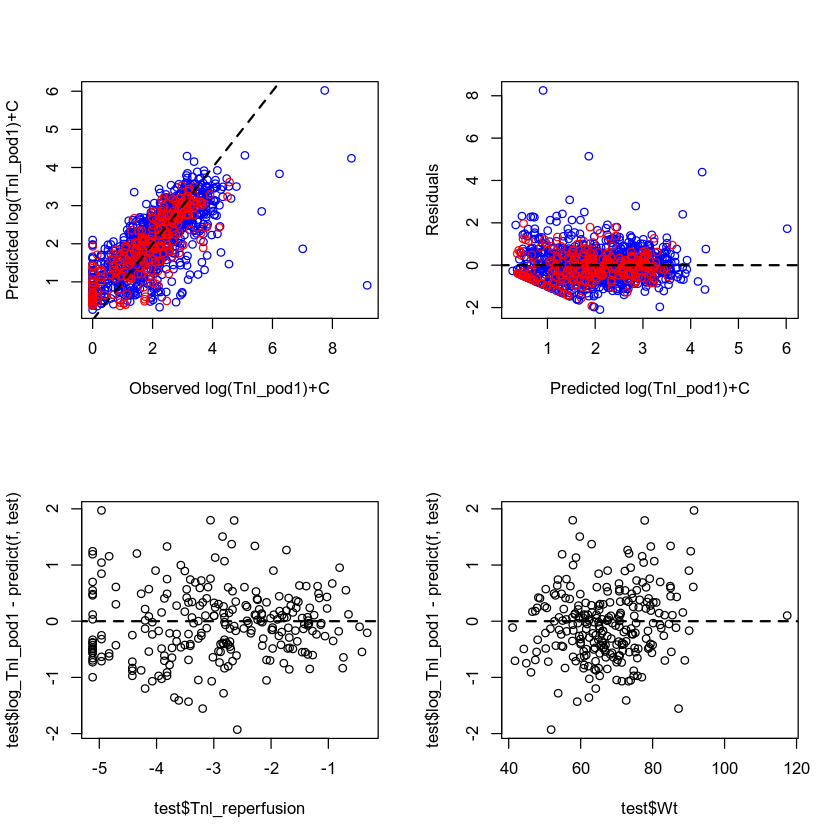

In [6]:
par(mfrow = c(2,2))
plot(train$log_TnI_pod1, predict(f, train), col='blue',# ylim=c(0,0.4), xlim=c(0,0.4), 
    #xlab='Observed log(TnI_pod1)-min(log(TnI_pod1))', ylab='Predicted log(TnI_pod1)-min(log(TnI_pod1))')
     xlab = 'Observed log(TnI_pod1)+C', ylab='Predicted log(TnI_pod1)+C')
points(test$log_TnI_pod1, predict(f, test), col='red')
lines(seq(0, 10), seq(0,10), col='black', lty=2, lwd=1.8)

plot(predict(f, train), train$log_TnI_pod1-predict(f, train), col='blue', 
   # ylim=c(-0.2, 0.4), xlim=c(0,0.5),
     ylab='Residuals', xlab='Predicted log(TnI_pod1)+C')
points(predict(f,test), test$log_TnI_pod1-predict(f, test), col='red')
lines(c(0.0, 10.0), c(0.0, 0.0), lty=2, lwd=1.8)

plot(test$Tnl_reperfusion, test$log_TnI_pod1-predict(f, test),  col='black')
lines(c(-6.0, 0.0), c(0.0, 0.0), lty=2, lwd=1.8)

plot(test$Wt, test$log_TnI_pod1-predict(f, test),  col='black')
lines(c(0, 130.0), c(0, 0), lty=2, lwd=1.8)

In [22]:
library(mgcv)

Warning message:
“package ‘mgcv’ was built under R version 3.6.3”This is mgcv 1.8-33. For overview type 'help("mgcv-package")'.


In [23]:
df = read.csv("../imputed_data/troponin_pod1_regression_imputed_data01.csv")

Ntrain <- floor(0.8 * nrow(df))
set.seed(123)
train_ind <- sample(seq_len(nrow(df)), size = Ntrain)

train <- df[train_ind, ]
test <- df[-train_ind, ]

In [25]:
f1 <- gam(TnI_pod1 ~ Tnl_reperfusion + FFP + Wt + Sex 
                    + Na_MELD + DBP_mean7 + HR_mean7, data=train, family=gammals)
summary(f1)

In [ ]:
gam.check(f1)

In [ ]:
par(mfrow = c(2,1))
plot(train$TnI_pod1, predict(f1, train), col='blue',#ylim=c(0,0.4), xlim=c(0,0.4), 
    xlab='Observed TnI pod1', ylab='Predicted TnI pod1')
points(test$TnI_pod1, predict(f1, test), col='red')
lines(seq(0, 3), seq(0,3), col='black', lty=2, lwd=1.5)

plot(predict(f1, train), train$TnI_pod1-predict(f1, train), col='black', 
   # ylim=c(-0.2, 0.4), xlim=c(0,0.5),
     ylab='Residuals', xlab='Observed TnI pod1')
points(predict(f1, test), test$TnI_pod1-predict(f1, test), col='red')
lines(c(0.0, 3.0), c(0.0, 0.0), col='black', lty=2, lwd=1.5)